In [4]:
#Importing all necessary dependencies.
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3
from keras.applications import resnet


image_path =keras.utils.get_file("test.jpg", "https://reason.com/wp-content/uploads/2022/08/florian-wehde-iVW7mZPwd4g-unsplash-scaled.jpg")
test=keras.utils.load_img(image_path)


layer_settings = {
    "mixed4": 1.1,
    "mixed6": 1.1,
    "mixed7": 1.3,
}

step = 0.01
num_octave = 2
octave_scale = 1.4
iterations = 13
max_loss = 15.0

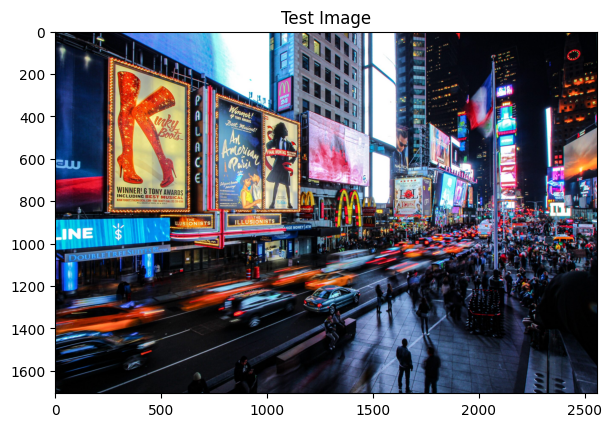

In [5]:
#Test Image.
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title("Test Image")
plt.imshow(test)

In [6]:
#Image Resizing in order to enhance the efficiency of the model.
from PIL import Image

img = Image.open(image_path)
img = img.resize((256,256), Image.LANCZOS)
img.size

(256, 256)

#### Functions for image preprocessing, and deprocessing to obtain an image from a numpy array generated by the model.

In [7]:
def preprocess_function(image_path):
    img = keras.utils.load_img(image_path)
    #Converting the image to a numpy array for further manipulation.
    img = keras.utils.img_to_array(img)
    #Adding a "batch size" of 1 to ensure the image is accepted as proper input.
    img = np.expand_dims(img, axis=0)
    #Normalising and Scaling the pixel values of the image.
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    #Reshaping the array to the (height,width,channels) format.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Reversing the inception_v4.preprocess_input steps.
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Making sure the pixel values lie well within the acceptable range of (0,255).
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [8]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [9]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

In [10]:
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

In [11]:
original_img = preprocess_function(image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)
result_prefix='fin'
keras.utils.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (1219, 1828)
... Loss value at step 0: 0.41
... Loss value at step 1: 0.52
... Loss value at step 2: 0.65
... Loss value at step 3: 0.78
... Loss value at step 4: 0.90
... Loss value at step 5: 1.02
... Loss value at step 6: 1.13
... Loss value at step 7: 1.24
... Loss value at step 8: 1.34
... Loss value at step 9: 1.44
... Loss value at step 10: 1.54
... Loss value at step 11: 1.64
... Loss value at step 12: 1.74
Processing octave 1 with shape (1707, 2560)
... Loss value at step 0: 0.59
... Loss value at step 1: 0.83
... Loss value at step 2: 1.01
... Loss value at step 3: 1.16
... Loss value at step 4: 1.31
... Loss value at step 5: 1.45
... Loss value at step 6: 1.57
... Loss value at step 7: 1.70
... Loss value at step 8: 1.83
... Loss value at step 9: 1.96
... Loss value at step 10: 2.09
... Loss value at step 11: 2.22
... Loss value at step 12: 2.36


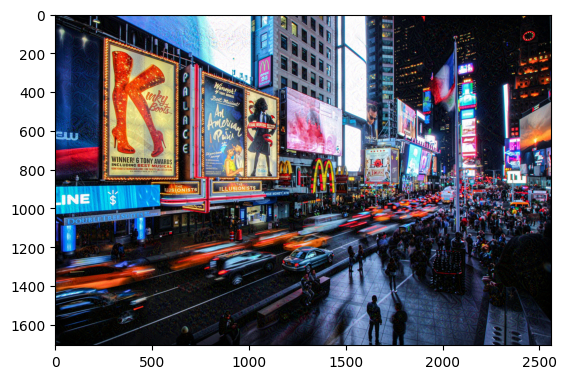

In [12]:
plt.imshow(keras.utils.load_img(result_prefix + ".png"))

In [43]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [44]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [51]:
from tensorflow.keras.preprocessing.image import load_img
content_path = result_prefix + ".png"
style_path = tf.keras.utils.get_file('style.jpg','https://upload.wikimedia.org/wikipedia/commons/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
style_image = load_img(style_path)

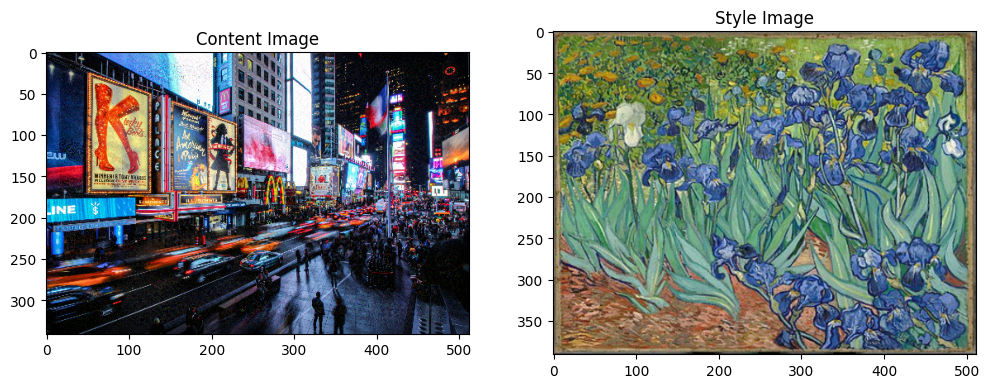

In [50]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1,2,2)
imshow(style_image, 'Style Image')


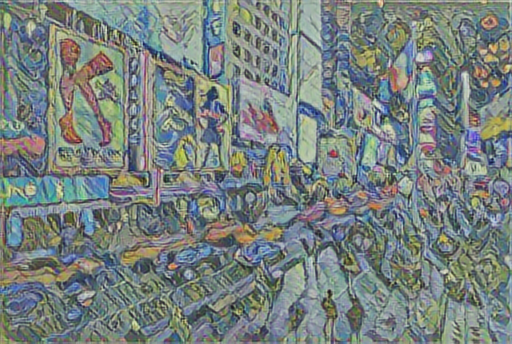

In [47]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
stylized_1=stylized_image
tensor_to_image(stylized_image)

In [52]:
from tensorflow.keras.applications.vgg19 import preprocess_input

def preprocess_functionvgg19(image_path):

    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    return img

In [ ]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert back to RGB from BGR

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [53]:
def gram_matrix(x):

    x = tf.transpose(x, (0 ,3, 1, 2))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))

    return gram

In [54]:
from tensorflow.keras.applications import VGG19
model = VGG19(
    include_top=False,
    weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers

model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [56]:
from tensorflow.keras import Model
# Content layer where will pull our feature maps
content_layers = ['block5_conv2']

# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
content_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [57]:
style_models = [Model(inputs=model.input,
                      outputs=model.get_layer(layer).output) for layer in style_layers]

In [ ]:
def get_model(styles, contents):
   vgg = kr.applications.vgg19.VGG19(include_top=False,
                                      weights='imagenet',
                                      input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    vgg.trainable = False

    # Get output layers corresponding to style and content layers
    style_outputs = [vgg.get_layer(layer_name).output for layer_name in styles]
    content_outputs = [vgg.get_layer(layer_name).output for layer_name in contents]
    model_outputs = style_outputs + content_outputs

    return kr.Model(vgg.input, model_outputs)

In [ ]:
def compute_loss(model, image, style_features, content_features, alpha=0.1, beta=0.002):
  # Feed our init image through our model.
    model_outputs = model(image)

    content_generated = [content_layer[0] for content_layer in model_outputs[len(style_layers):]][0]
    style_generated = [style_layer for style_layer in model_outputs[:len(style_layers)]]

    content_loss = alpha * get_content_loss(content_features, content_generated)
    style_loss = beta * get_style_loss(style_features, style_generated)

    # Get total loss
    loss = style_loss + content_loss
    return loss

In [ ]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        loss = compute_loss(**cfg)
    # Compute gradients with respect to input image
    return tape.gradient(loss, cfg['image']), loss

In [ ]:
def transfer_style(content_img, style_img, epochs=1000):
    def generate_noisy_image(content_image, noise_ratio):
        """Generates a noisy image by adding random noise to the content image"""

        noise_image = tf.random.uniform([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3], minval=-20, maxval=20)
        input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
        return input_image

    # We don't want to train any layers of our model
    model = get_model(style_layers, content_layers)
    for layer in model.layers:
        layer.trainable = False

    S = load_image(style_img)
    C = load_image(content_img)
    def transfer_style(content_img, style_img, epochs=1000):
    def generate_noisy_image(content_image, noise_ratio):
        """Generates a noisy image by adding random noise to the content image"""

        noise_image = tf.random.uniform([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3], minval=-20, maxval=20)
        input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
        return input_image

    # We don't want to train any layers of our model
    model = get_model(style_layers, content_layers)
    for layer in model.layers:
        layer.trainable = False

    S = load_image(style_img)
    C = load_image(content_img)

    style_outputs = model(S)
    content_outputs = model(C)

    # Get the style and content feature representations (from our specified intermediate layers)
    _content = [content_layer[0] for content_layer in content_outputs[len(style_layers):]][0]
    _style = [style_layer[0] for style_layer in style_outputs[:len(style_layers)]]

    # Set initial image
    G = generate_noisy_image(C, 0.6)
    G = tf.contrib.eager.Variable(G, dtype=tf.float32)

    best_loss, best_img = float('inf'), None

    # Create a nice config
    cfg = {
        'model': model,
        'image': G,
        'style_features': _style,
        'content_features': _content
    }

    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
    # For displaying
    display_interval = epochs/(2*5)

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(epochs):
        grads, cost = compute_grads(cfg)
        opt.apply_gradients([(grads, G)])
        clipped = tf.clip_by_value(G, min_vals, max_vals)
        G.assign(clipped)

        if cost < best_loss:
            best_loss = cost
            best_img = deprocess_img(G.numpy())

        if i % display_interval== 0:
            plot_img = G.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            display.clear_output(wait=True)
            display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}, LOSS: {:.4e}'.format(i, cost))


    display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

In [ ]:
best, best_loss = transfer_style(CONTENT, STYLE, epochs=200)

In [58]:
weight_of_layer = 1. / len(style_models)
def style_cost(style, generated):
    J_style = 0
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * weight_of_layer
    return J_style

In [59]:
def content_cost(base, layer):
    return tf.reduce_sum(tf.square(layer - base))

In [62]:

# training function
generated_images = []


def training_loop(content_path, style_path, iterations=30, a=15, b=500):
    # load content and style images from their respective path
    content = preprocess_functionvgg19(content_path)
    style = preprocess_functionvgg19(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=2)
    from numpy import inf
    best_cost = inf
    best_image = None
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style

        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print("Iteration :{}".format(i))
        print('Total Loss {:e}.'.format(J_total))
        generated_images.append(generated.numpy())

    return best_image

In [ ]:
final_img = training_loop(content_path, style_path)